# FDE Wind Power Generation Prediction

In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
%cd drive/MyDrive/FDE

/content/drive/MyDrive/FDE


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import warnings
import sys
from datetime import datetime, timedelta

import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
%pip install pmdarima
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from prophet import Prophet

In [7]:
wind_actual = pd.read_csv('Wind_Actual.csv')
wind_forecast = pd.read_csv('Wind_Forecast.csv')
new_data = pd.read_csv('new_data.csv')

# EDA

Sneak peak of our data and some basic information.

In [8]:
wind_actual.head()

,DATE,HE,Trading_Hub,Renewable_Type,MW
0,2023-01-01,1,SP15,Wind,2108.04570
1,2023-01-01,2,SP15,Wind,2563.03702
2,2023-01-01,3,SP15,Wind,2799.13237
3,2023-01-01,4,SP15,Wind,2659.33710
4,2023-01-01,5,SP15,Wind,2224.13754


In [9]:
wind_forecast.head()

,DATE,HE,Trading_Hub,Renewable_Type,MW
0,2023-01-01,1,SP15,Wind,2474.02
1,2023-01-01,2,SP15,Wind,2581.14
2,2023-01-01,3,SP15,Wind,2663.81
3,2023-01-01,4,SP15,Wind,2707.74
4,2023-01-01,5,SP15,Wind,2717.96


In [10]:
wind_forecast.tail()

,DATE,HE,Trading_Hub,Renewable_Type,MW
10316,2024-03-15,20,SP15,Wind,190.73
10317,2024-03-15,21,SP15,Wind,178.21
10318,2024-03-15,22,SP15,Wind,183.09
10319,2024-03-15,23,SP15,Wind,181.59
10320,2024-03-15,24,SP15,Wind,192.76


In [11]:
wind_actual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10536 entries, 0 to 10535
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATE            10536 non-null  object 
 1   HE              10536 non-null  int64  
 2   Trading_Hub     10536 non-null  object 
 3   Renewable_Type  10536 non-null  object 
 4   MW              10536 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 411.7+ KB


In [12]:
wind_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10321 entries, 0 to 10320
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATE            10321 non-null  object 
 1   HE              10321 non-null  int64  
 2   Trading_Hub     10321 non-null  object 
 3   Renewable_Type  10321 non-null  object 
 4   MW              10321 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 403.3+ KB


### Helper Functions

In [13]:
def new_data_prep(df, df_type):
    # Prepping data from 3/16-4/7

    copy = df.copy()
    copy = copy[(copy['TRADING_HUB'] == 'SP15') & (copy['RENEWABLE_TYPE'] == 'Wind')]

    if df_type == 'actual':
        copy = copy[copy['MARKET_RUN_ID'] == 'ACTUAL']
    else:
        copy = copy[copy['MARKET_RUN_ID'] == 'DAM']

    copy = copy.rename({'OPR_DT': 'DATE', 'OPR_HR': 'HE'}, axis = 1)
    copy = copy[['DATE', 'HE', 'MW']]
    copy = copy.sort_values(['DATE', 'HE'])

    return copy

def pipeline(df, df_type, new_data):
    #Pipeline for data prep for modeling
    copy = df.copy()

    #Dropping useless columns
    copy = copy.drop(columns = ['Trading_Hub', 'Renewable_Type'], axis = 1)

    # Fixing errors
    # 7401 has a HE as 25, so I corrected them as 24. In wind_forecast 2023-11-05, 7177 HE was 25, but the day
    # started with HE 2, so I shifted the day back by one HE. I noticed the MW values seems to be off compared to
    # the values beside it, but I'm not sure what caused it so I didn't want to drop them.
    if df_type == 'actual':
        copy.loc[7401, 'HE'] = 24
    else:
        copy.iloc[7154:7178].loc[:, 'HE'] -= 1

    # Adding new data
    copy = pd.concat([copy, new_data])

    return copy

def add_datetime(df):
    # Add datetime as DATE + HE, and set as index

    copy = df.copy()
    copy['datetime'] = copy['DATE'] + ' ' + (copy['HE'] - 1).astype(str) + ':00:00'
    copy['datetime'] = pd.to_datetime(copy['datetime'])
    copy = copy.set_index('datetime')[['MW']]

    return copy

def plotting(df, start, end):
    # Plotting data

    if start == end:
        df[['MW']].plot(style = '-', figsize = (15, 5), title = 'Entire Dataset')
    elif end != None:
        df.loc[df.index < end][['MW']].plot(style = '-', figsize = (15, 5), title = f'Until {end}')
    else:
        df.loc[df.index > start][['MW']].plot(style = '-', figsize = (15, 5), title = f'Starting {start}')

def actual_vs_forecast(actual, forecast, img_name, provided_forecast = None):
    # Plot actual vs forecasted values
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.plot(actual)
    plt.plot(forecast)
    if provided_forecast is not None:
        plt.plot(provided_forecast)
        plt.legend(['Actual', 'Forecast', 'Baseline Forecast'])
    else:
        plt.legend(['Actual', 'Forecast'])
    plt.title(img_name)
    plt.show()
    plt.savefig(img_name)
    plt.clf()

def add_fourier_terms(df, week_k, day_k):
    # Add fourier terms to replicate multiple seasonality

    for k in range(1, week_k+1):
        # week has a period of 7
        df['week_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofweek/7)
        df['week_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofweek/7)

    for k in range(1, day_k+1):
        # day has period of 24
        df['hour_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.hour/24)
        df['hour_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.hour/24)

def df_train_test_split(df, split_date):
    # Train test split with X_train, y_train, X_test, and y_train

    copy = df.copy()
    train = copy.loc[df.index < split_date]
    test = copy.loc[df.index >= split_date]

    X_train = train.drop(['MW'], axis = 1)
    X_test = test.drop(['MW'], axis = 1)
    y_train = train['MW']
    y_test = test['MW']

    return X_train, X_test, y_train, y_test

def series_train_test_split(series, split_date):
    # Train test split only y_train and y_test

    copy = series.copy()
    train = copy.loc[series.index < split_date]
    test = copy.loc[series.index >= split_date]

    return train, test

def plotting_split(train, test):
    # Plotting train test split

    fig, ax = plt.subplots(figsize=(15, 5))
    train.plot(ax = ax, label = 'Train Set', title = 'Data Train/Test Split')
    test.plot(ax = ax, label = 'Test Set')
    ax.axvline('04-06-2024', color='black', ls='--')
    plt.show()

### Prepping Data for Modeling

In [14]:
new_data_actual = new_data_prep(new_data, 'actual')
new_data_forecast = new_data_prep(new_data, 'forecast')

df_actual = pipeline(wind_actual, 'actual', new_data_actual)
df_forecast = pipeline(wind_forecast, 'forecast', new_data_forecast)

df_actual, df_forecast = add_datetime(df_actual), add_datetime(df_forecast)

In [15]:
df_actual.head()

,MW
datetime,
2023-01-01 00:00:00,2108.04570
2023-01-01 01:00:00,2563.03702
2023-01-01 02:00:00,2799.13237
2023-01-01 03:00:00,2659.33710
2023-01-01 04:00:00,2224.13754


In [16]:
df_forecast.head()

,MW
datetime,
2023-01-01 00:00:00,2474.02
2023-01-01 01:00:00,2581.14
2023-01-01 02:00:00,2663.81
2023-01-01 03:00:00,2707.74
2023-01-01 04:00:00,2717.96


# Plots and Seasonality Check

### I first want to see the data in general

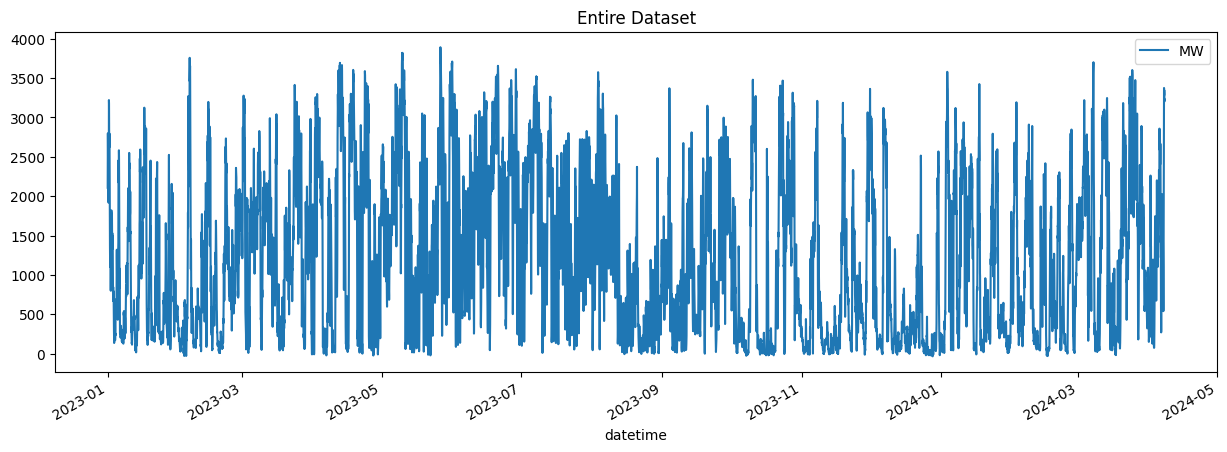

In [17]:
plotting(df_actual, None, None)

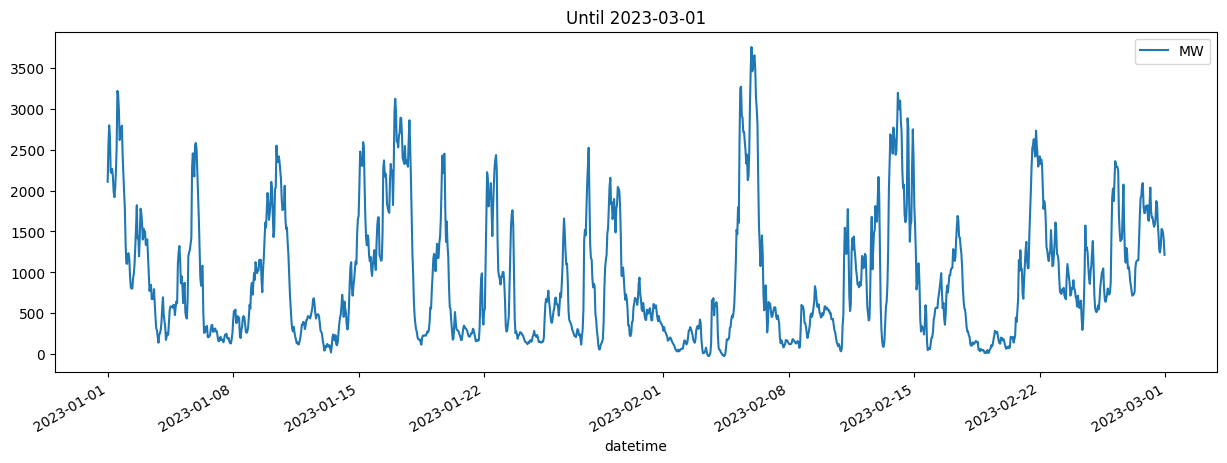

In [18]:
plotting(df_actual, None, '2023-03-01')

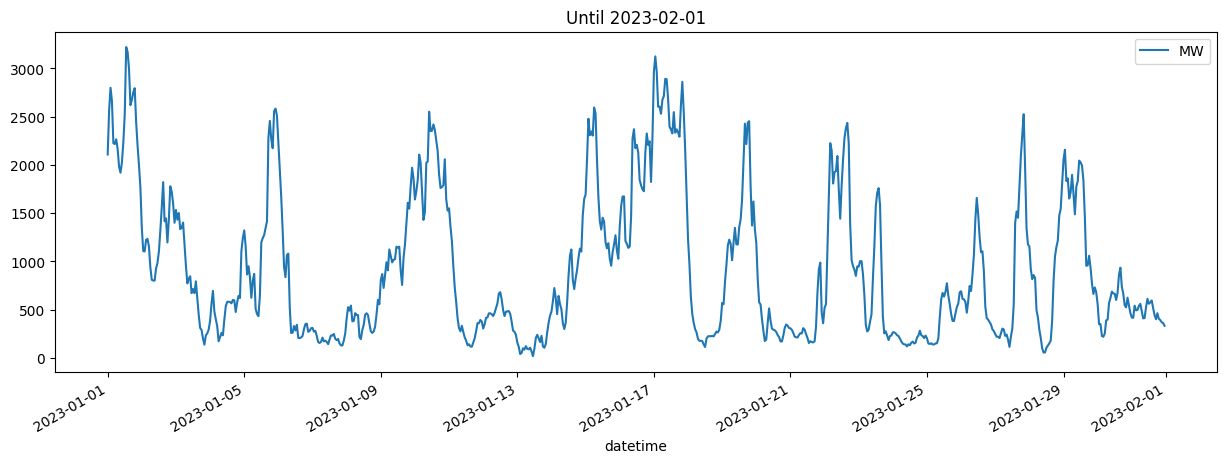

In [19]:
plotting(df_actual, None, '2023-02-01')

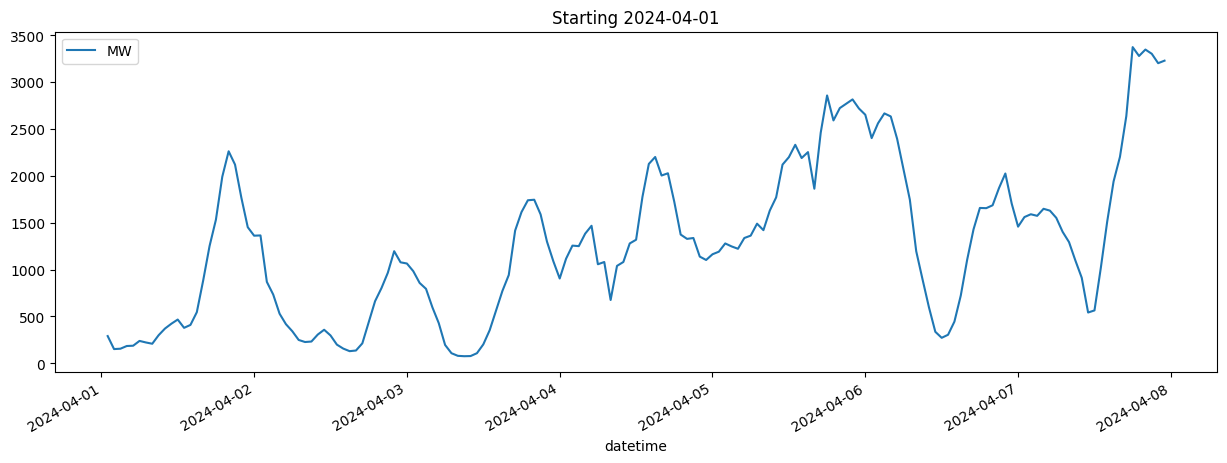

In [20]:
plotting(df_actual, '2024-04-01', None)

#### This is our target prediction for modeling (2024-04-07)

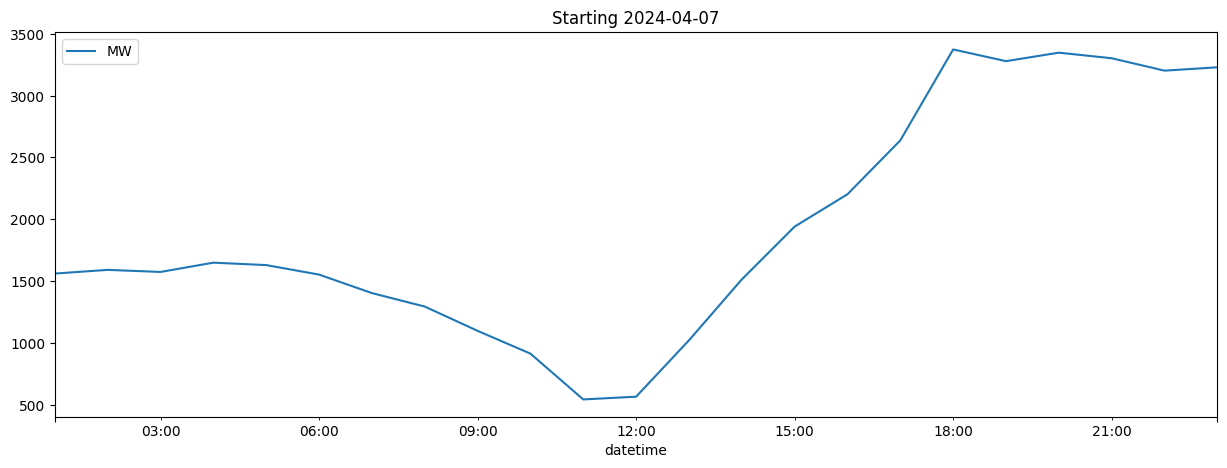

In [21]:
plotting(df_actual, '2024-04-07', None)

### I don't see a very obvious trend or seasonality, so I used a ACF Plot to check for repeated lag values

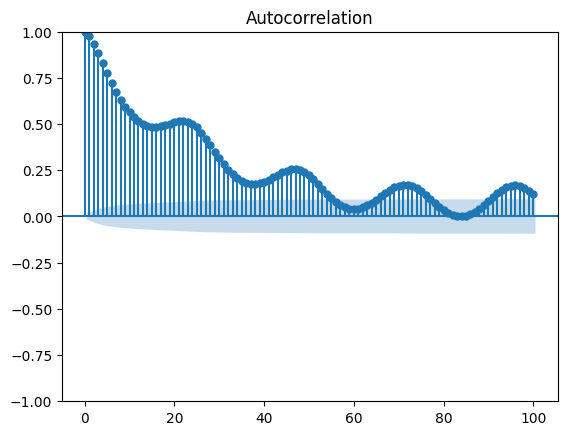

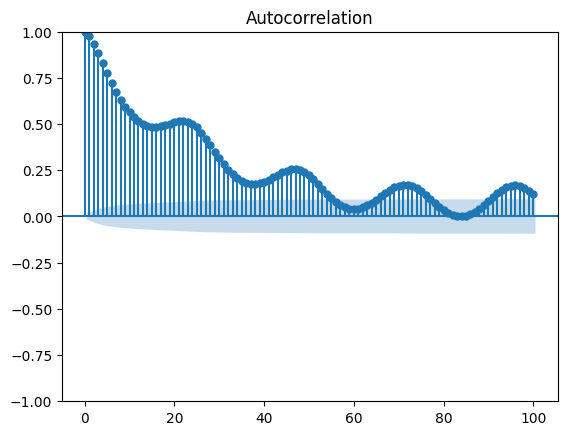

In [22]:
from statsmodels.graphics.tsaplots import plot_acf

#Spanning over 3-4 days
plot_acf(df_actual['MW'], lags = 100)

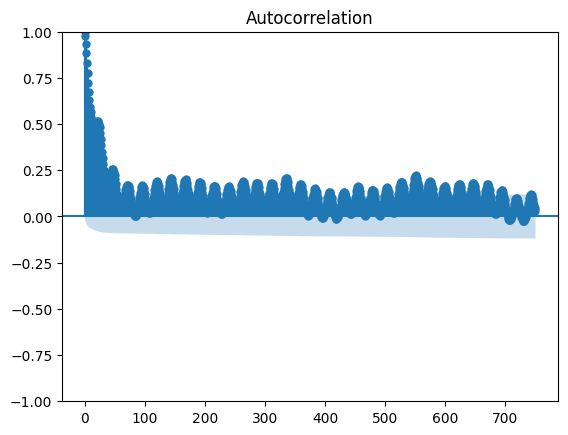

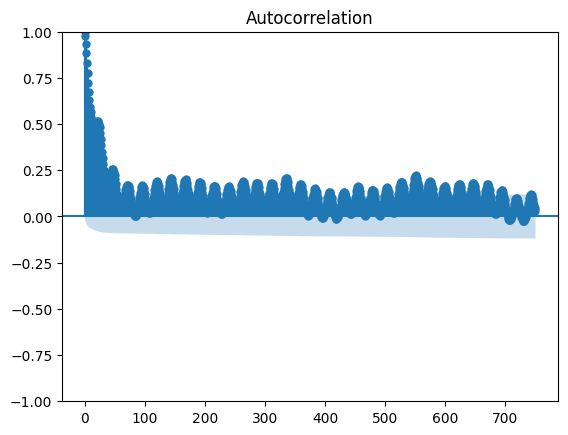

In [23]:
#Spanning over a month
plot_acf(df_actual['MW'], lags = 750)

#### ACF measures correlation between a value and its lagged values, and from the two plots, I only see a daily seasonality

# Base Score

I'm using the given forecasts as a base score for our forecast. It'll give me an idea of how well my model is doing. I'll be using Root Mean Squared Error (rmse) as my metric.

In [24]:
test_MW_actual = df_actual.loc[df_actual.index >= '2024-04-07']['MW']
test_MW_forecast = df_forecast.loc[df_forecast.index >= '2024-04-07']['MW']

In [26]:
rmse_base = np.sqrt(mean_squared_error(test_MW_actual, test_MW_forecast))
print(f'Baseline RMSE: {rmse_base}')

Baseline RMSE: 724.9602012471884


#### Plotting Actual vs Forecast

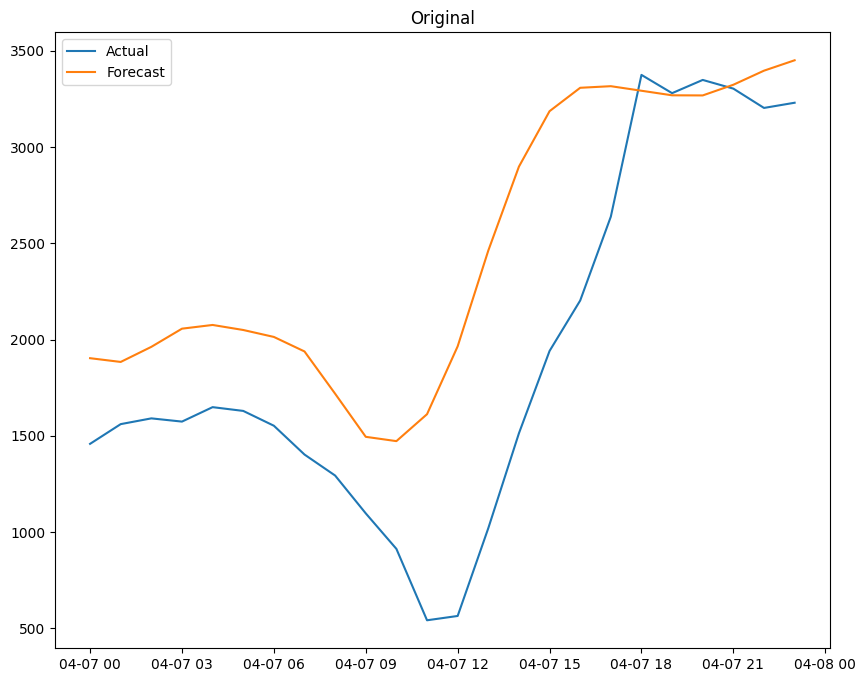

<Figure size 640x480 with 0 Axes>

In [27]:
actual_vs_forecast(test_MW_actual, test_MW_forecast, img_name = 'Original')

I am predicting April 7th's 24 hour wind generation, while training on all the data prior to April 7th. As we can see the forecast captures the overall trend very well, and our **rmse** is around **724**.

# Modeling

## XGBoost

In [28]:
# Create new features for xgb

xgb_df = df_actual.copy()
xgb_df['HE'] = xgb_df.index.hour.astype('category')
xgb_df['month'] = xgb_df.index.month.astype('category')
xgb_df['quarter'] = xgb_df.index.quarter.astype('category')

In [29]:
#gridsearchcv for parameter tuning

'''warnings.filterwarnings('ignore')

estimator = xgb.XGBRegressor(objective = 'reg:linear', booster = 'gbtree', seed = 42)
parameters = {
    'max_depth': [3, 5, 8, 10],
    'n_estimators': [1000, 10000],
    'learning_rate': [0.01, 0.001, 0.0001]
}

grid_search = GridSearchCV(
    estimator = estimator,
    param_grid = parameters,
    scoring = 'neg_mean_squared_error',
    cv = 5,
    verbose = 10,
    error_score = 'raise'
)

grid_search.fit(X_train, y_train)'''

"warnings.filterwarnings('ignore')\n\nestimator = xgb.XGBRegressor(objective = 'reg:linear', booster = 'gbtree', seed = 42)\nparameters = {\n    'max_depth': [3, 5, 8, 10],\n    'n_estimators': [1000, 10000],\n    'learning_rate': [0.01, 0.001, 0.0001]\n}\n\ngrid_search = GridSearchCV(\n    estimator = estimator,\n    param_grid = parameters,\n    scoring = 'neg_mean_squared_error',\n    cv = 5,\n    verbose = 10,\n    error_score = 'raise'\n)\n\ngrid_search.fit(X_train, y_train)"

In [34]:
def xgb_pipeline(df, xgb_type):
    # Pipeline for training and testing xgboost model

    X_train, X_test, y_train, y_test = df_train_test_split(df, '2024-04-07')
    reg = xgb.XGBRegressor(
        objective = 'reg:linear',
        booster = 'gbtree',
        seed = 42,
        max_depth = 10,
        n_estimators = 1000,
        learning_rate = 0.01,
        enable_categorical=True
    )

    reg.fit(X_train, y_train, verbose = 10)

    fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
    fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')
    plt.show()

    prediction = pd.Series(reg.predict(X_test), index = y_test.index)
    actual_vs_forecast(y_test, prediction, xgb_type, test_MW_forecast)
    rmse = np.sqrt(mean_squared_error(prediction, y_test))
    print(f'RMSE Score on Test set: {rmse}')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [02:29:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


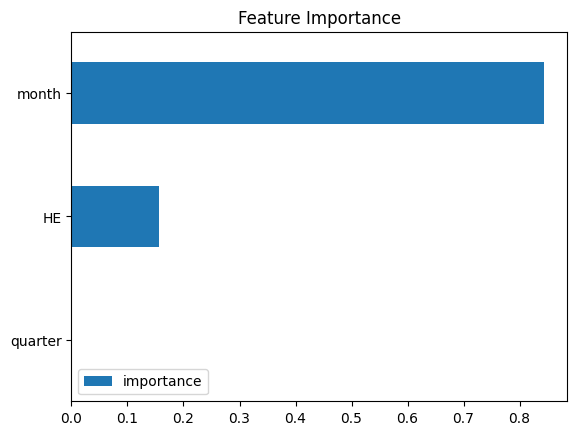

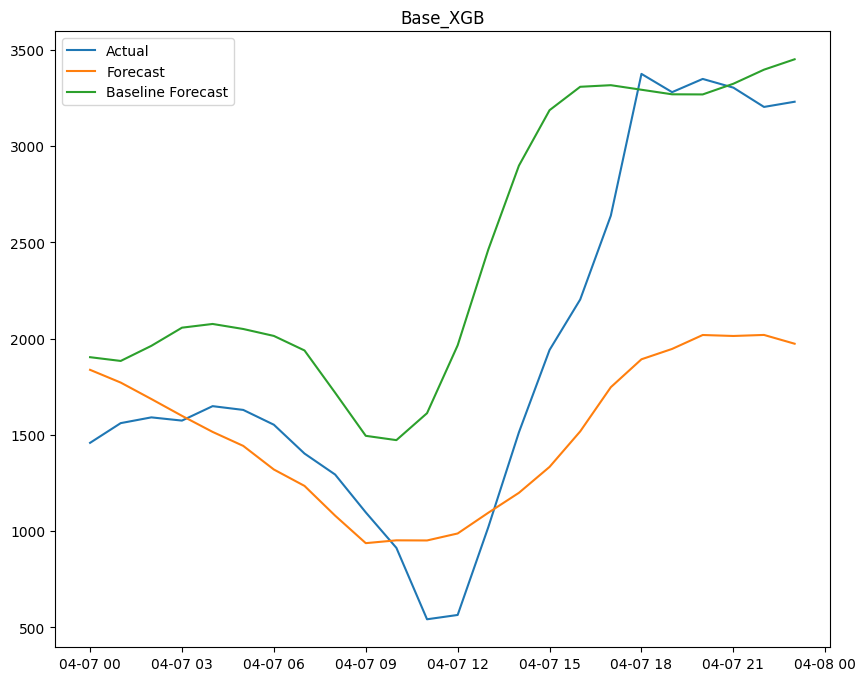

RMSE Score on Test set: 732.4051638678776


<Figure size 640x480 with 0 Axes>

In [35]:
xgb_pipeline(xgb_df, 'Base_XGB')

## XGBoost with Forier Series

In [32]:
def add_fourier_terms(df, week_k, day_k):
    # Add fourier series to data
    copy = df.copy()

    for k in range(1, week_k+1):
        # week has a period of 7
        copy['week_sin'+str(k)] = np.sin(2 *k* np.pi * copy.index.dayofweek/7)
        copy['week_cos'+str(k)] = np.cos(2 *k* np.pi * copy.index.dayofweek/7)

    for k in range(1, day_k+1):
        # day has period of 24
        copy['hour_sin'+str(k)] = np.sin(2 *k* np.pi * copy.index.hour/24)
        copy['hour_cos'+str(k)] = np.cos(2 *k* np.pi * copy.index.hour/24)

    return copy

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [02:29:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


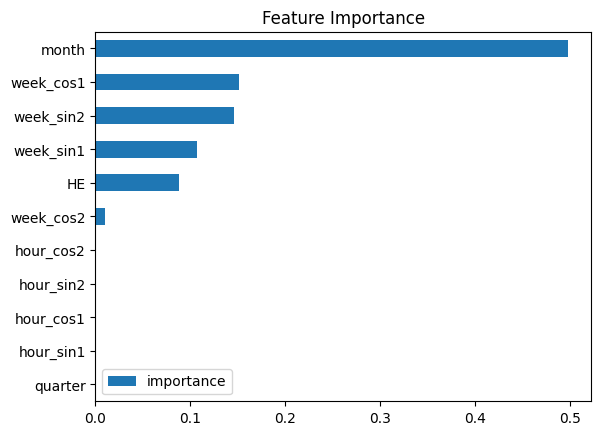

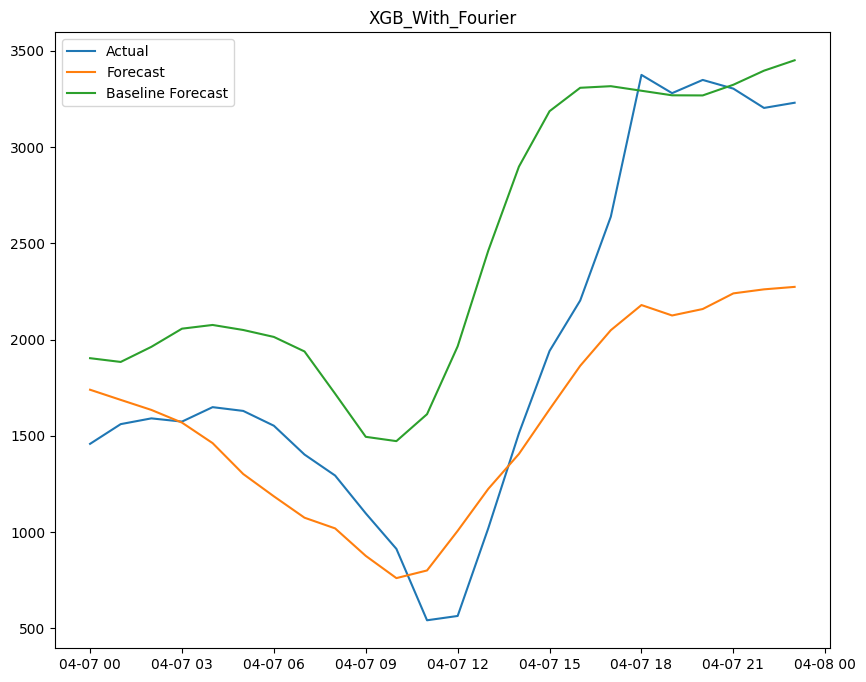

RMSE Score on Test set: 598.8472324944339


<Figure size 640x480 with 0 Axes>

In [36]:
# Adding fourier terms to xgb_df
xgb_df_fourier = add_fourier_terms(xgb_df, 2, 2)
xgb_pipeline(xgb_df_fourier, 'XGB_With_Fourier')

## XGBoost with Fourier and Lagged Values

In [37]:
def add_lagged(df):
    # Add lagged value 24 hours prior
    copy = df.copy()

    for i in range(24, 49):
        copy['lag'+str(i+1)] = copy['MW'].shift(i+1)
        copy = copy.dropna()

    return copy

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [02:30:43] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


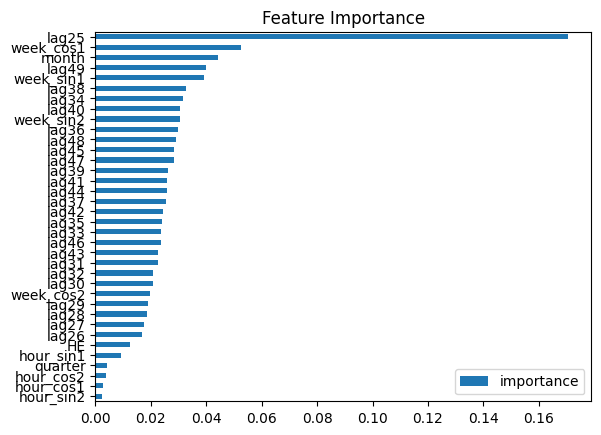

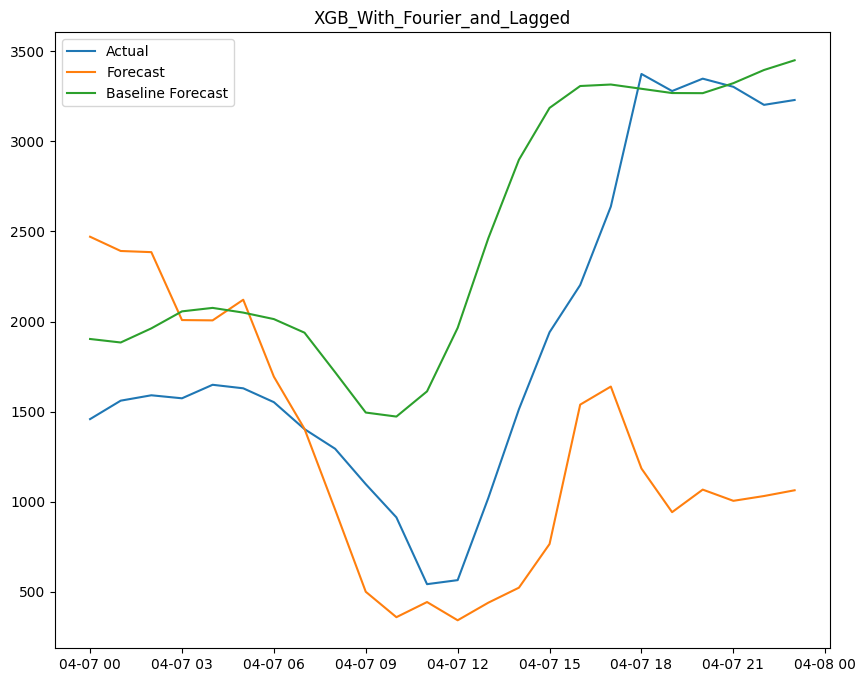

RMSE Score on Test set: 1259.2183163485868


<Figure size 640x480 with 0 Axes>

In [38]:
xgb_df_fourier_lagged = add_lagged(xgb_df_fourier)
xgb_pipeline(xgb_df_fourier_lagged, 'XGB_With_Fourier_and_Lagged')

After trying three xgboost models, we conclude that **xgboost with fourier series worked the best**. With lagged values, it would be ideal if we're only predicted **one hour** ahead, but that's not what we want here. We could only use lagged values starting from 24 hours prior, which affected our prediction poorly.

I actually tried the **rolling forecast method**, which uses a model's previous prediction on its current prediction. But as I expected the result isn't great because the further the prediction the worse it gets.

## SARIMAX

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMAX Tuner

'''stepwise_fit = auto_arima(
    y_train['MW'],
    start_p=1,
    start_q=1,
    max_p=3,
    m=24,
    start_P=0,
    seasonal=True,
    d=1,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True)
'''

"stepwise_fit = auto_arima(\n    y_train['MW'],\n    start_p=1, \n    start_q=1,\n    max_p=3, \n    max_q=3, \n    m=12, \n    start_P=0, \n    seasonal=True, \n    d=1, \n    D=1, \n    trace=True, \n    error_action='ignore', \n    suppress_warnings=True, \n    stepwise=True)\n"

In [42]:
# We're using XGB_DF here because we want the quarter variable. We only want the quarter variable because SARIMAX
# already sees month and hour in our datetime index

# Train-Test split for SARIMAX
X_train, X_test, y_train, y_test = df_train_test_split(xgb_df, '2024-04-07')
X_train = X_train[['quarter']]
X_test = X_test[['quarter']]

In [49]:
def sarimax_pipeline(y_train, sarimax_type, X_train = None, X_test = None):
    # Sarimax pipeline
    # For SARIMA, there are no exogenous data, so when function call I just left X_train and X_test alone
    # For SARIMAX, I would pass in X_train and X_test for training and testing

    # For parameters, I mainly used auto_arima for search over the grid of parameters
    # So save time I set d and D to 1 because I want to do differencing for the model
    # I set m = 24 because we have a 24 hour cycle
    sarimax = SARIMAX(y_train, order = (2, 1, 0), seasonal_order = (3, 1, 0, 24), exog = X_train)
    model_fitted = sarimax.fit()

    # Training
    sarimax_pred = model_fitted.forecast(24, exog = X_test)

    # Predicting, plotting and error
    prediction = pd.Series(sarimax_pred, index = test_MW_actual.index)
    actual_vs_forecast(test_MW_actual, prediction, sarimax_type, test_MW_forecast)
    rmse = np.sqrt(mean_squared_error(prediction, test_MW_actual))
    print(f'RMSE Score on Test set: {rmse}')

In [44]:
# SARIMA
#sarimax_pipeline(y_train, 'Base_Sarima')

In [45]:
# SARIMAX with quarter information
#sarimax_pipeline(y_train, 'SARIMAX', X_train, X_test)

I ran these on a remote server because it was taking too long. The performance of SARIMA and SARIMAX were both underwhelming, both having an rmse of around **900**. These are the plots.

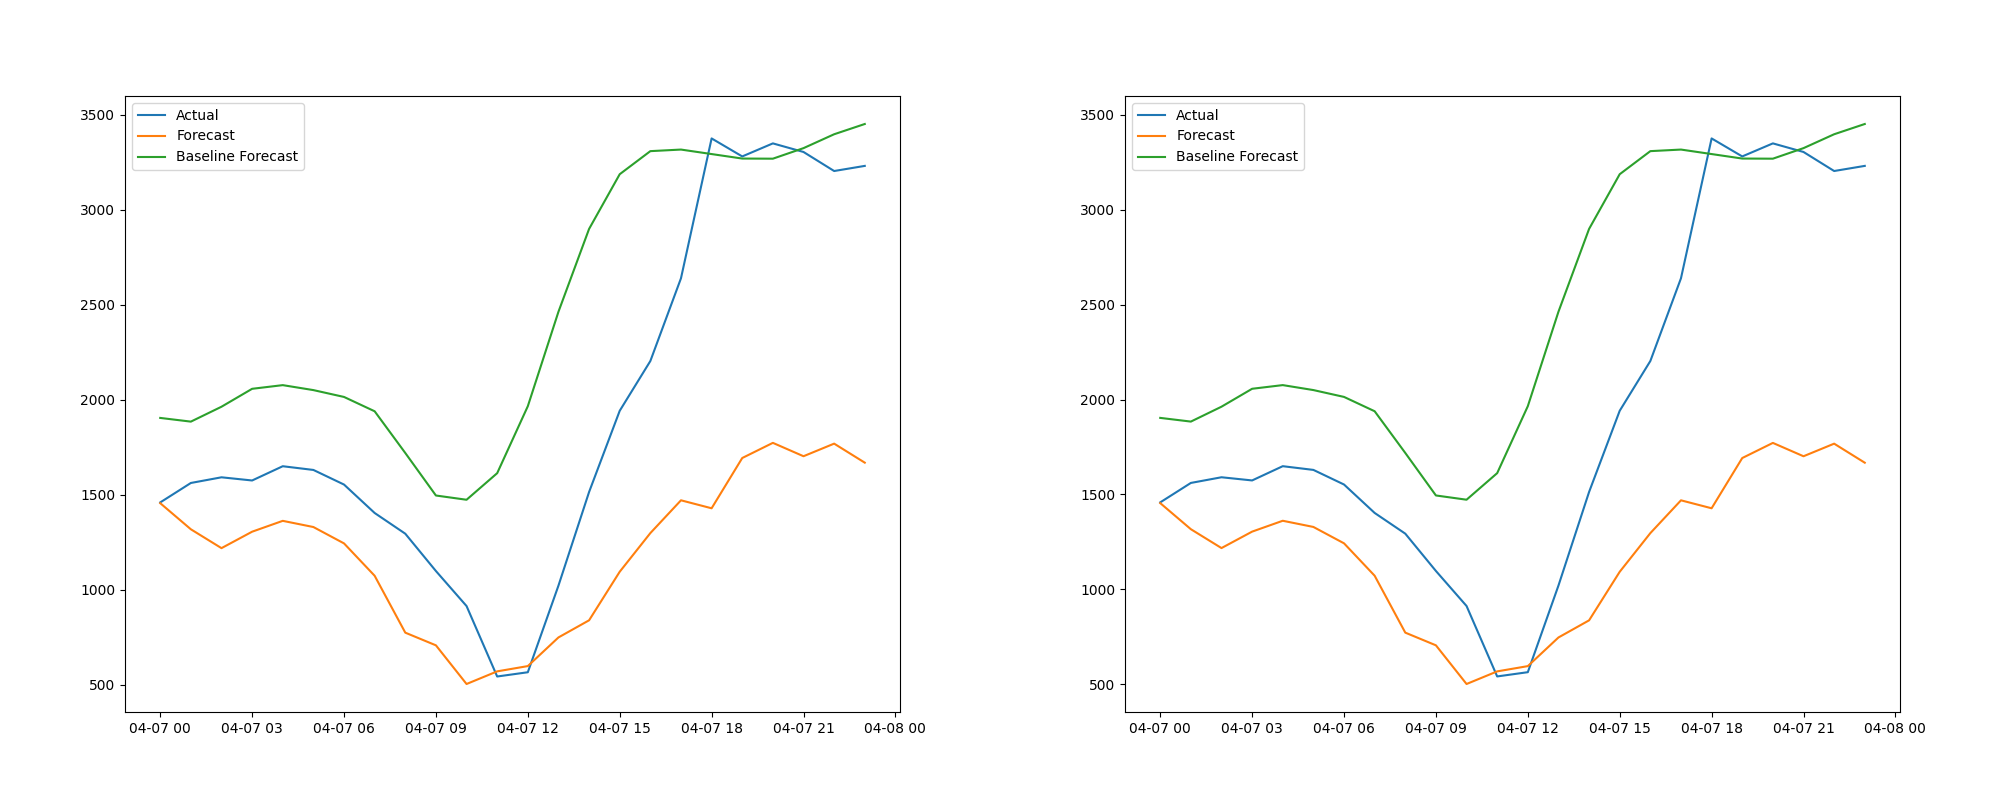

In [46]:
import cv2
from google.colab.patches import cv2_imshow
img1 = cv2.imread('Base_Sarima.png')
img2 = cv2.imread('SARIMAX.png')
Hori = np.concatenate((img1, img2), axis=1)
cv2_imshow(Hori)

## FB Prophet

In [47]:
%pip install prophet

In [48]:
def prophet_pipeline(xgb_df):
    # Pipeline for prophet training

    # Train-Test Split
    train, test = xgb_df.loc[xgb_df.index < '2024-04-07'], xgb_df.loc[xgb_df.index >= '2024-04-07']

    # FB Prophet requires a specific data format, converting datetime to ds and target variable to y
    prophet_train = train.reset_index()
    prophet_train = prophet_train.rename(columns = {'datetime': 'ds', 'MW': 'y'})[['ds', 'y']]
    prophet_test = test.reset_index()
    prophet_test = prophet_test.rename(columns = {'datetime': 'ds', 'MW': 'y'})[['ds', 'y']]

    # Training
    model = Prophet()
    model.fit(prophet_train)

    # Predicting
    future_dates = model.make_future_dataframe(periods=len(prophet_test), freq='h')
    forecasts = model.predict(future_dates)['yhat'][-24:].values

    # Plotting and Error
    prediction = pd.Series(forecasts, index = test_MW_actual.index)
    actual_vs_forecast(test_MW_actual, prediction, 'Prophet', test_MW_forecast)
    rmse = np.sqrt(mean_squared_error(prediction, test_MW_actual))
    print(f'RMSE Score on Test set: {rmse}')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp24vekqtr/c3b77cj3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp24vekqtr/udjppxr8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65007', 'data', 'file=/tmp/tmp24vekqtr/c3b77cj3.json', 'init=/tmp/tmp24vekqtr/udjppxr8.json', 'output', 'file=/tmp/tmp24vekqtr/prophet_model86nacru2/prophet_model-20240409024121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


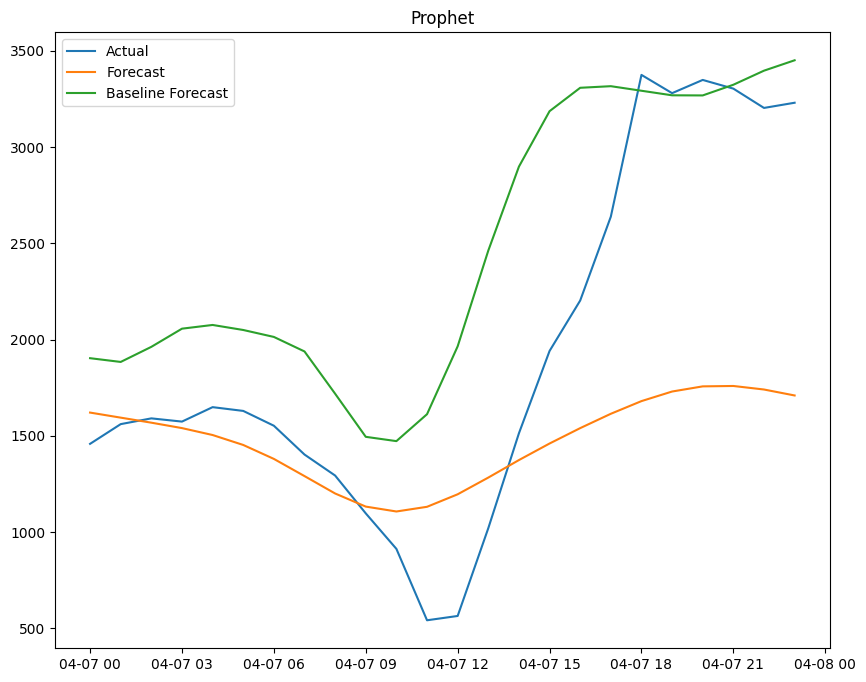

RMSE Score on Test set: 850.4758252970581


<Figure size 640x480 with 0 Axes>

In [50]:
prophet_pipeline(xgb_df)

FB Prophet also didn't do great. The overall trend was captured but I think it was smoothened a bit too much.

# Prediction Submission

The model I chose is XGB with Fourier Terms:

In [51]:
def submission_pipeline(xgb_df):
    # Pipeline for submission prediction

    # Create X_train and X_test for submission
    submission_train = xgb_df.copy()
    X_train = submission_train.drop('MW', axis = 1)
    y_train = submission_train['MW']
    submission_test = X_train.copy()
    submission_test.index = submission_test.index + timedelta(days = 1)
    submission_test['HE'] = submission_test.index.hour.astype('category')
    submission_test['month'] = submission_test.index.month.astype('category')
    submission_test['quarter'] = submission_test.index.quarter.astype('category')
    submission_test = submission_test.iloc[-24:]
    add_fourier_terms(submission_test, 2, 2)

    #Train XGBoost
    reg = xgb.XGBRegressor(
        objective = 'reg:linear',
        booster = 'gbtree',
        seed = 42,
        max_depth = 10,
        n_estimators = 1000,
        learning_rate = 0.01,
        enable_categorical=True
    )
    reg.fit(X_train, y_train, verbose = 10)
    prediction = pd.Series(reg.predict(submission_test), index = submission_test.index)
    prediction.plot()

    # Make prediction a dataframe and convert to csv
    prediction_df = wind_actual.copy()
    prediction_df = prediction_df.iloc[:24]
    prediction_df = prediction_df.replace({'2023-01-01': '2024-04-08'})
    prediction_df.loc[:, 'MW'] = prediction.values
    prediction_df.to_csv('2024-04-09_Pred_Richard_Wang.csv', index = False)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [02:42:58] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


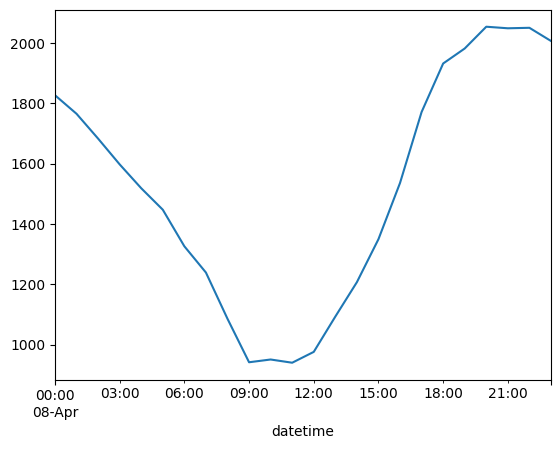

In [52]:
submission_pipeline(xgb_df)

# Summary

Here's a table for all the model I tried and the results:

In [55]:
d = {
    'Model': ['XGBoost', 'XGBoost + Fourier Series', 'XGBoost + Fourier + Lagged', 'SARIMA', 'SARIMAX', 'FB Prophet', 'Given Baseline'],
    'RMSE': [732.41, 598.84, 1259.22, 925.19, 925.19, 850.48, 724.96]
}
result_df = pd.DataFrame(d).sort_values('RMSE')
result_df

,Model,RMSE
1,XGBoost + Fourier Series,598.84
6,Given Baseline,724.96
0,XGBoost,732.41
5,FB Prophet,850.48
3,SARIMA,925.19
4,SARIMAX,925.19
2,XGBoost + Fourier + Lagged,1259.22


Our best best model is the **XGBoost with Fourier Series model**.

## Some notes

This was my first time doing a very specific **time series analysis and forecasting** problem. I've done mostly projects on machine learning and neural networks, but mainly on regression and classification tasks focusing on numerical/categorical variables or images/audio.

If I could go back to Friday, some things I would change was definitely focusing more on understanding the nuances of time series forecasting. There are many to consider, such as univariate/multivariate problems, single/multiple seasonalities, the amount of data at hand, hourly/daily/monthly/yearly data, and much more. I think if I had spent more time on these first I would've had more time fine-tuning my models, or even try more models. A model I would try if I had time was **LSTM**.

I also tried to look for pre-trained models, as I thought the data we have at hand is not necessarily large. I went to huggingface and tried some models (Lag-LLAMA for example) but they were all not well. Most of them focuses on in-sample forecasting rather than out-sample, which is what we want. It could be because using more sophiscated deep learning methods on time series forecasting is a relatively new subject, and it's definitely worth my time researching after this project.

Another interesting question I see many discussions on is to use **deep learning/machine learning methods** like XGBoost and LSTM methods, **or traditional time series methods like ARIMA/TBATS**. However after reading many many articles and papers I thought autoregressive models like ARIMA would work quite nicely, since I don't see much seasonality other than hourly trends. I also sticked with ARIMA because I didn't see weekly/monthly seasonalities. In hindsight SARIMAX might've not been great because I also added seasonal quarters for XGBoost. SARIMAX could only handle a single seasonality, so maybe I should've tried TBATS and include quarterly seasonality (spring, summer, fall, winter).

To be safe I also tried FB's Prophet model, which automatically detects seasonalities, but it didn't perform well. I read a lot about adding holidays/weekdays features, but I feel like intuitively wind generation/weather is not really affected by these factors.

I think all my models caught the general trend of the data, but there are still large rooms for improvements. If I had more time, I would focus more on researching about fine-tuning these models, or trying LSTM/TBATS.

I hope you enjoy reading this project, and please let me know if you have any questions or suggestions. Thank you!

-Richard